<a href="https://colab.research.google.com/github/nikiduki/ts_ml/blob/master/traiding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [447]:
!pip install yfinance
!pip install catboost
!pip install optuna
import optuna
import xgboost
import catboost
import lightgbm as lgb
import numpy as np
import yfinance as yf
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


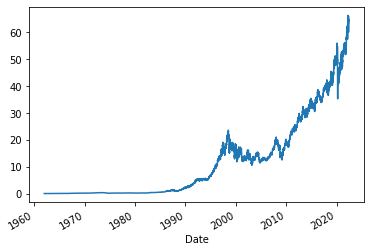

In [448]:
tickerSymbol = 'KO'
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='max')

tickerDf.Close.plot()

In [449]:
tickerDf.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1962-01-02,0.050745,0.052126,0.050745,0.050745,806400,0.0,0.0
1962-01-03,0.049991,0.049991,0.048860,0.049614,1574400,0.0,0.0
1962-01-04,0.049740,0.050368,0.049740,0.049991,844800,0.0,0.0
1962-01-05,0.049991,0.050619,0.048735,0.048860,1420800,0.0,0.0
1962-01-08,0.048484,0.048484,0.047416,0.048358,2035200,0.0,0.0


In [450]:
del_columns = {'Volume', 'Dividends', 'Stock Splits'}
for col in del_columns:
  tickerDf = tickerDf.drop(col, axis=1)

tickerDf.head()

,Open,High,Low,Close
Date,,,,
1962-01-02,0.050745,0.052126,0.050745,0.050745
1962-01-03,0.049991,0.049991,0.048860,0.049614
1962-01-04,0.049740,0.050368,0.049740,0.049991
1962-01-05,0.049991,0.050619,0.048735,0.048860
1962-01-08,0.048484,0.048484,0.047416,0.048358


In [451]:
def get_columns(data, columns_data, col_shift, size_table=10):
  for i in range(1, size_table+1):
    col_name = f'shift_{col_shift}_{i}'
    data[col_name] = data[col_shift].shift(i)
    columns_data.append(col_name)
  data = data.dropna()
  return data

In [452]:
def get_features(data, col_pred):
  columns_data = [f'{col_pred}_pct_change']
  for column in data.columns:
    data[f'{column}_pct_change'] = data[column].pct_change()
    col_shift = f'{column}_pct_change'
    data = get_columns(data, columns_data, col_shift, size_table=10)
    if column!=col_pred:
      data = data.drop(column, axis=1)
      data = data.drop(f'{column}_pct_change', axis=1)
  X = data[columns_data[1:]].values
  y = data[columns_data[0]].values.reshape(-1, 1)
  display(data)
  return X, y

In [453]:
def un_pct_change(diff, orig):
  un_pct_change = (orig.shift(1) * diff.ravel()) + orig.shift(1)
  return un_pct_change[1:]

In [454]:
def metrics(pred, target):
  mse = mean_squared_error(pred, target)
  mae = mean_absolute_error(pred, target)
  mape = mean_absolute_percentage_error(pred, target)
  return mse, mae, mape

In [455]:
def objectives_ridge(trial):
  alpha = trial.suggest_uniform('alpha', 0.0, 0.05)
  model = Ridge(alpha=alpha)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE

In [456]:
def objectives_lasso(trial):
  alpha = trial.suggest_uniform('alpha', 0.0, 0.1)
  model = Lasso(alpha=alpha)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE

In [457]:
def objectives_cb(trial):
  params_cb = {
                "subsample": trial.suggest_float("subsample", 0.5, 0.99),
                'od_wait': trial.suggest_int('od_wait', 10, 50, step=1),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 0.99),
                "random_strength": trial.suggest_int("random_strength", 1, 10, step=1),
                "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 50.0),
                "max_depth": trial.suggest_int("max_depth", 4, 10, step=1),
                "n_estimators": trial.suggest_int("n_estimators", 100, 2500, step=1),
                'learning_rate': trial.suggest_loguniform("learning_rate", 0.005, 0.1),
                'random_state': 0,
                'loss_function': 'MAE', 
                'eval_metric': 'MAE', 
                'one_hot_max_size': 0,
                'boost_from_average': True
              }
  model = catboost.CatBoostRegressor(**params_cb)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE

In [458]:
def objectives_lgb(trial):
  params_lgb = {
            'num_leaves': trial.suggest_int('num_leaves', 200, 3000),
            'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
            'max_bin': trial.suggest_int('max_bin', 2, 100),
            'learning_rate': trial.suggest_uniform('learning_rate',0, 1),
                  }
  model = lgb.LGBMRegressor(**params_lgb)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE         

In [459]:
def objectives_rf(trial):
  params_rf = {
          'max_depth' : trial.suggest_int('max_depth', 1, 500),
          'max_features' : trial.suggest_categorical('max_features', ['auto', 'sqrt','log2']),
          'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 1, 1000),
          'n_estimators' :  trial.suggest_int('n_estimators', 30, 1000)
            }

  model = RandomForestRegressor(**params_rf)
  model.fit(X_train, y_train.ravel())
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE         

In [460]:
def objectives_dtr(trial):
  params_dtr = {
            "splitter": trial.suggest_categorical("splitter", ["best","random"]),
            "max_depth" : trial.suggest_int("max_depth", 1, 12),
            "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 10),
            "min_weight_fraction_leaf" : trial.suggest_uniform("min_weight_fraction_leaf", 0.05, 0.5),
            "max_features" : trial.suggest_categorical("max_features", ["auto","log2","sqrt",None]),
            "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes", 10, 90, 10)
            }
  model = DecisionTreeRegressor(**params_dtr)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE

In [461]:
def objectives_reg(trial):
  params_reg = {}
  model = LinearRegression(**params_reg)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(pred, y_test)
  return MSE

In [462]:
optuna_objectives = {
                     'LinearRegression' : objectives_reg,
                     'LinearRegression_ridge' : objectives_ridge,
                     'LinearRegression_lasso' : objectives_lasso,
                     'CatBoostRegressor' : objectives_cb,
                     'DecisionTreeRegressor' : objectives_dtr,
                     'LGBMRegressor' : objectives_lgb,
                     'RandomForestRegressor' : objectives_rf
                     }
params_models_High = {
                    'LinearRegression' : {},
                    'LinearRegression_ridge' : {'alpha': 0.719015801147572},
                    'LinearRegression_lasso' : {'alpha': 1.0976270078546495},
                    'CatBoostRegressor' : {'subsample': 0.8576953755877884, 'od_wait': 17, 'colsample_bylevel': 0.7553079370400233, 'random_strength': 1, 'l2_leaf_reg': 10.799829719923604, 'max_depth': 4, 'n_estimators': 2005, 'learning_rate': 0.0097791867608511},
                    'DecisionTreeRegressor' : {'splitter': 'best', 'max_depth': 8, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.05929294975957791, 'max_features': 'auto', 'max_leaf_nodes': 80},
                    'LGBMRegressor' : {'num_leaves': 1842, 'n_estimators': 158, 'max_bin': 84, 'learning_rate': 0.004695476192547066},
                    'RandomForestRegressor' : {'max_depth': 481, 'max_features': 'auto', 'max_leaf_nodes': 17, 'n_estimators': 932}
                } 
params_models_Low = {
                    'LinearRegression' : {},
                    'LinearRegression_ridge' : {'alpha': 0.719015801147572},
                    'LinearRegression_lasso' : {'alpha': 1.0976270078546495},
                    'CatBoostRegressor' : {'subsample': 0.8576953755877884, 'od_wait': 17, 'colsample_bylevel': 0.7553079370400233, 'random_strength': 1, 'l2_leaf_reg': 10.799829719923604, 'max_depth': 4, 'n_estimators': 2005, 'learning_rate': 0.0097791867608511},
                    'DecisionTreeRegressor' : {'splitter': 'best', 'max_depth': 8, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.05929294975957791, 'max_features': 'auto', 'max_leaf_nodes': 80},
                    'LGBMRegressor' : {'num_leaves': 1842, 'n_estimators': 158, 'max_bin': 84, 'learning_rate': 0.004695476192547066},
                    'RandomForestRegressor' : {'max_depth': 481, 'max_features': 'auto', 'max_leaf_nodes': 17, 'n_estimators': 932}
                }      
params_models_default = {
                    'LinearRegression' : {},
                    'LinearRegression_ridge' : {},
                    'LinearRegression_lasso' : {},
                    'CatBoostRegressor' : {},
                    'DecisionTreeRegressor' : {},
                    'LGBMRegressor' : {},
                    'RandomForestRegressor' : {}
                }                  
params_models = {
                  'High': params_models_High,
                  'Low': params_models_Low,
                  'Close': params_models_default,
                  'Open': params_models_default
                }
models = {
          'LinearRegression' : LinearRegression,
          'LinearRegression_ridge' : Ridge, 
          'LinearRegression_lasso' : Lasso, 
          'DecisionTreeRegressor' : DecisionTreeRegressor, 
          'RandomForestRegressor' : RandomForestRegressor, 
          'LGBMRegressor' : lgb.LGBMRegressor,
          'CatBoostRegressor' : catboost.CatBoostRegressor
          }

In [463]:
def pipeline(model_name, data_df, col_pred, train=False, n_optuna=None, metrics_flag=False):
  data = data_df.copy()
  X, y = get_features(data, col_pred)
  global X_train, y_train, X_test, y_test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False, random_state=42)

  # optuna
  if n_optuna is None:
    model = models[model_name](**params_models[col_pred][model_name])
  else:
    opt = optuna.create_study(direction='minimize',sampler=optuna.samplers.RandomSampler(seed=0))
    opt.optimize(optuna_objectives[model_name], n_trials=n_optuna)
    trial = opt.best_trial
    params_best = dict(trial.params.items())     
    model = models[model_name](**params_best) 

  model.fit(X_train, y_train)
  if train:
    pred = model.predict(X_train)
    un_pct_change_pred = un_pct_change(pred, data[col_pred][len(data) - len(pred):])
    un_pct_change_target = un_pct_change(y_train, data[col_pred][len(data) - len(pred):])
  else:
    pred = model.predict(X_test)
    un_pct_change_pred = un_pct_change(pred, data[col_pred][len(data) - len(pred):])
    un_pct_change_target = un_pct_change(y_test, data[col_pred][len(data) - len(pred):])
  if metrics_flag:
    mse, mae, mape = metrics(un_pct_change_pred, un_pct_change_target)
    print('\n-----------------------------------------------'
        f'\nMetrics of prediction {col_pred} of {model_name}:\n'
        f'\n\tMSE = {mse}'
        f'\n\tMAE = {mae}'
        f'\n\tMAPE = {mape}')

  return un_pct_change_pred

In [464]:
def trading(preds_high, preds_low, target_high, target_low, target_close, L=1):
  profit = 0
  pos = False
  num_steps = len(target_close)
  success_deals = 0
  failed_deals = 0
  deals = []
  commission = 0
  for step in range(num_steps):
    buy_price = preds_low[step] / L
    sell_price = preds_high[step] * L
    if buy_price >= target_low[step]:
      pos = True
      profit -= commission / 100 * buy_price
    if pos:
      if sell_price <= target_high[step]:
        p = sell_price - buy_price
        success_deals += 1
        status = 'success'
      else:
        sell_price = target_close[step]
        p = sell_price - buy_price
        failed_deals += 1
        status = 'failed'
      profit += p
      pos = False
      deals.append({
        'status' : status,
        'buy_price' : buy_price,
        'sell_price' : sell_price,
        'profit' : p,
        'total_profit' : profit,
        'success_deals' : success_deals,
        'failed_deals' : failed_deals
      })
  return deals

In [465]:
preds = {
         'High': pd.DataFrame(),
         'Low': pd.DataFrame()
        }
for col in preds.keys():
  for name_model in models.keys():
    print(f'\n---------------------------{name_model}---------------------------\n')
    preds[col][name_model] = pipeline(name_model, tickerDf, col, n_optuna=None, metrics_flag=True)
  preds[col][col] = tickerDf[col][(len(tickerDf[col]) - len(y_test))+1:]


---------------------------LinearRegression---------------------------



,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046725,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,0.008089,...,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348,0.016308
1962-03-07,0.046725,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,...,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348
1962-03-08,0.046599,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,...,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379
1962-03-09,0.046411,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811
1962-03-12,0.046725,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,63.099998,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,64.190002,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,64.470001,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687



-----------------------------------------------
Metrics of prediction High of LinearRegression:

	MSE = 0.07885096750861291
	MAE = 0.16550608271133727
	MAPE = 0.005912862153935601

---------------------------LinearRegression_ridge---------------------------



,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046725,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,0.008089,...,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348,0.016308
1962-03-07,0.046725,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,...,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348
1962-03-08,0.046599,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,...,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379
1962-03-09,0.046411,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811
1962-03-12,0.046725,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,63.099998,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,64.190002,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,64.470001,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687



-----------------------------------------------
Metrics of prediction High of LinearRegression_ridge:

	MSE = 0.08664093758463755
	MAE = 0.17483930137973658
	MAPE = 0.006233518414730367

---------------------------LinearRegression_lasso---------------------------



,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046725,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,0.008089,...,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348,0.016308
1962-03-07,0.046725,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,...,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348
1962-03-08,0.046599,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,...,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379
1962-03-09,0.046411,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811
1962-03-12,0.046725,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,63.099998,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,64.190002,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,64.470001,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687



-----------------------------------------------
Metrics of prediction High of LinearRegression_lasso:

	MSE = 0.10411859831471441
	MAE = 0.19091952247174673
	MAPE = 0.0068249764097254775

---------------------------DecisionTreeRegressor---------------------------



,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046725,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,0.008089,...,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348,0.016308
1962-03-07,0.046725,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,...,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348
1962-03-08,0.046599,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,...,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379
1962-03-09,0.046411,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811
1962-03-12,0.046725,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,63.099998,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,64.190002,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,64.470001,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687



-----------------------------------------------
Metrics of prediction High of DecisionTreeRegressor:

	MSE = 0.09146315130893728
	MAE = 0.18694942758045874
	MAPE = 0.006622899563646235

---------------------------RandomForestRegressor---------------------------



,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046725,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,0.008089,...,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348,0.016308
1962-03-07,0.046725,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,...,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348
1962-03-08,0.046599,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,...,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379
1962-03-09,0.046411,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811
1962-03-12,0.046725,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,63.099998,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,64.190002,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,64.470001,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



-----------------------------------------------
Metrics of prediction High of RandomForestRegressor:

	MSE = 0.08491589276355979
	MAE = 0.17874480101805265
	MAPE = 0.006350181438552328

---------------------------LGBMRegressor---------------------------



,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046725,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,0.008089,...,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348,0.016308
1962-03-07,0.046725,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,...,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348
1962-03-08,0.046599,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,...,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379
1962-03-09,0.046411,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811
1962-03-12,0.046725,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,63.099998,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,64.190002,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,64.470001,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



-----------------------------------------------
Metrics of prediction High of LGBMRegressor:

	MSE = 0.08657813804387957
	MAE = 0.17569487556528215
	MAPE = 0.00625923037172211

---------------------------CatBoostRegressor---------------------------



,High,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046725,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,0.008089,...,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348,0.016308
1962-03-07,0.046725,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,...,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348
1962-03-08,0.046599,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,...,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379
1962-03-09,0.046411,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811
1962-03-12,0.046725,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,63.099998,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,64.190002,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,64.470001,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687


0:	learn: 0.0139372	total: 6.16ms	remaining: 12.3s
1:	learn: 0.0139143	total: 12.4ms	remaining: 12.4s
2:	learn: 0.0138899	total: 18.3ms	remaining: 12.2s
3:	learn: 0.0138649	total: 23.7ms	remaining: 11.9s
4:	learn: 0.0138410	total: 29.1ms	remaining: 11.7s
5:	learn: 0.0138172	total: 34.7ms	remaining: 11.6s
6:	learn: 0.0137933	total: 40ms	remaining: 11.4s
7:	learn: 0.0137697	total: 45.7ms	remaining: 11.4s
8:	learn: 0.0137500	total: 51.4ms	remaining: 11.4s
9:	learn: 0.0137283	total: 57.1ms	remaining: 11.4s
10:	learn: 0.0137044	total: 65.5ms	remaining: 11.9s
11:	learn: 0.0136843	total: 70.9ms	remaining: 11.8s
12:	learn: 0.0136632	total: 76.2ms	remaining: 11.7s
13:	learn: 0.0136462	total: 81.6ms	remaining: 11.6s
14:	learn: 0.0136260	total: 87.2ms	remaining: 11.6s
15:	learn: 0.0136050	total: 95.4ms	remaining: 11.9s
16:	learn: 0.0135860	total: 101ms	remaining: 11.8s
17:	learn: 0.0135659	total: 106ms	remaining: 11.7s
18:	learn: 0.0135462	total: 111ms	remaining: 11.6s
19:	learn: 0.0135285	total:

,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046223,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,0.008089,...,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348,0.016308
1962-03-07,0.046097,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,...,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348
1962-03-08,0.045971,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,...,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379
1962-03-09,0.045343,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811
1962-03-12,0.046223,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,61.590000,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,62.750000,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,63.599998,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687



-----------------------------------------------
Metrics of prediction Low of LinearRegression:

	MSE = 0.09878628750530996
	MAE = 0.1719157570300204
	MAPE = 0.00612139757326078

---------------------------LinearRegression_ridge---------------------------



,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046223,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,0.008089,...,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348,0.016308
1962-03-07,0.046097,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,...,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348
1962-03-08,0.045971,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,...,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379
1962-03-09,0.045343,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811
1962-03-12,0.046223,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,61.590000,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,62.750000,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,63.599998,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687



-----------------------------------------------
Metrics of prediction Low of LinearRegression_ridge:

	MSE = 0.10746833579291826
	MAE = 0.18142516524950075
	MAPE = 0.006473132025204083

---------------------------LinearRegression_lasso---------------------------



,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046223,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,0.008089,...,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348,0.016308
1962-03-07,0.046097,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,...,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348
1962-03-08,0.045971,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,...,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379
1962-03-09,0.045343,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811
1962-03-12,0.046223,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,61.590000,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,62.750000,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,63.599998,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687



-----------------------------------------------
Metrics of prediction Low of LinearRegression_lasso:

	MSE = 0.1244894550624602
	MAE = 0.19973602285538192
	MAPE = 0.007213204894293821

---------------------------DecisionTreeRegressor---------------------------



,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046223,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,0.008089,...,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348,0.016308
1962-03-07,0.046097,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,...,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348
1962-03-08,0.045971,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,...,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379
1962-03-09,0.045343,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811
1962-03-12,0.046223,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,61.590000,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,62.750000,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,63.599998,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687



-----------------------------------------------
Metrics of prediction Low of DecisionTreeRegressor:

	MSE = 0.11517967092598579
	MAE = 0.1913175024880621
	MAPE = 0.006840057409697132

---------------------------RandomForestRegressor---------------------------



,Low,shift_Open_pct_change_1,shift_Open_pct_change_2,shift_Open_pct_change_3,shift_Open_pct_change_4,shift_Open_pct_change_5,shift_Open_pct_change_6,shift_Open_pct_change_7,shift_Open_pct_change_8,shift_Open_pct_change_9,...,shift_Close_pct_change_1,shift_Close_pct_change_2,shift_Close_pct_change_3,shift_Close_pct_change_4,shift_Close_pct_change_5,shift_Close_pct_change_6,shift_Close_pct_change_7,shift_Close_pct_change_8,shift_Close_pct_change_9,shift_Close_pct_change_10
Date,,,,,,,,,,,,,,,,,,,,,
1962-03-06,0.046223,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,0.008089,...,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348,0.016308
1962-03-07,0.046097,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,-0.005346,...,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379,-0.005348
1962-03-08,0.045971,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,-0.005381,...,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811,-0.005379
1962-03-09,0.045343,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,-0.010810,...,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397,-0.010811
1962-03-12,0.046223,0.002725,-0.013445,0.010874,-0.002710,0.008196,-0.002725,-0.016089,0.002688,0.016397,...,-0.010869,0.002724,-0.013444,0.021981,-0.013550,0.010958,-0.005449,-0.018719,0.005376,0.016397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,61.590000,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,0.000465,...,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286,-0.002008
2022-05-24,62.750000,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,-0.002636,...,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687,-0.009286
2022-05-25,63.599998,0.019951,0.019177,-0.007710,-0.068175,-0.010287,0.010086,0.009721,0.010131,-0.002643,...,0.018454,0.030830,0.016333,-0.019608,-0.069626,-0.002729,0.003652,0.018757,0.003110,0.004687


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


KeyboardInterrupt: ignored

In [ ]:
for df in preds.values():
  display(df)

In [ ]:
metrics_df = pd.DataFrame(index = ('MSE', 'MAE', 'MAPE'))
for col_pred, df in preds.items():
  for column in df.columns[:-1]:
    pred = df[col_pred]
    target = df[column]
    metrics_df[column] = metrics(pred, target)

In [ ]:
metrics_df

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(preds['High']['High'].loc['2022-04-23':'2022-05-25'], label='target', color='b')
plt.plot(preds['High']['CatBoostRegressor'].loc['2022-04-23':'2022-05-25'], label='CatBoost', color='red')
plt.plot(preds['High']['LGBMRegressor'].loc['2022-04-23':'2022-05-25'], label='LightGBM', color='cyan')
plt.plot(preds['High']['DecisionTreeRegressor'].loc['2022-04-23':'2022-05-25'], label='DecisionTree', color='green')
plt.plot(preds['High']['LinearRegression_ridge'].loc['2022-04-23':'2022-05-25'], label='Ridge', color='purple')
plt.plot(preds['High']['LinearRegression_lasso'].loc['2022-04-23':'2022-05-25'], label='Lasso', color='orange')
plt.plot(preds['High']['LinearRegression'].loc['2022-04-23':'2022-05-25'], label='Regression', color='black')
plt.plot(preds['High']['RandomForestRegressor'].loc['2022-04-23':'2022-05-25'], label='RandomForest', color='black')
plt.title('High: Target vs Pred')
plt.ylabel('High price')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(preds['Low']['Low'].loc['2022-04-23':'2022-05-25'], label='target', color='b')
plt.plot(preds['Low']['CatBoostRegressor'].loc['2022-04-23':'2022-05-25'], label='CatBoost', color='red')
plt.plot(preds['Low']['LGBMRegressor'].loc['2022-04-23':'2022-05-25'], label='LightGBM', color='cyan')
plt.plot(preds['Low']['DecisionTreeRegressor'].loc['2022-04-23':'2022-05-25'], label='DecisionTree', color='green')
plt.plot(preds['Low']['LinearRegression_ridge'].loc['2022-04-23':'2022-05-25'], label='Ridge', color='purple')
plt.plot(preds['Low']['LinearRegression_lasso'].loc['2022-04-23':'2022-05-25'], label='Lasso', color='orange')
plt.plot(preds['Low']['LinearRegression'].loc['2022-04-23':'2022-05-25'], label='Regression', color='black')
plt.plot(preds['Low']['RandomForestRegressor'].loc['2022-04-23':'2022-05-25'], label='RandomForest', color='black')
plt.title('Low: Target vs Pred')
plt.ylabel('Low price')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
dtr_df = pd.DataFrame(trading(preds['High']['DecisionTreeRegressor'], preds['Low']['DecisionTreeRegressor'], preds['High']['High'], preds['Low']['Low'], tickerDf['Close'][len(tickerDf['Close'])-len(preds['High']['High']):]))
rf_df = pd.DataFrame(trading(preds['High']['RandomForestRegressor'], preds['Low']['RandomForestRegressor'], preds['High']['High'], preds['Low']['Low'], tickerDf['Close'][len(tickerDf['Close'])-len(preds['High']['High']):]))
reg_l_df = pd.DataFrame(trading(preds['High']['LinearRegression_lasso'], preds['Low']['LinearRegression_lasso'], preds['High']['High'], preds['Low']['Low'], tickerDf['Close'][len(tickerDf['Close'])-len(preds['High']['High']):]))
reg_r_df = pd.DataFrame(trading(preds['High']['LinearRegression_ridge'], preds['Low']['LinearRegression_ridge'], preds['High']['High'], preds['Low']['Low'], tickerDf['Close'][len(tickerDf['Close'])-len(preds['High']['High']):]))
lgb_df = pd.DataFrame(trading(preds['High']['LGBMRegressor'], preds['Low']['LGBMRegressor'], preds['High']['High'], preds['Low']['Low'], tickerDf['Close'][len(tickerDf['Close'])-len(preds['High']['High']):]))
cb_df = pd.DataFrame(trading(preds['High']['CatBoostRegressor'], preds['Low']['CatBoostRegressor'], preds['High']['High'], preds['Low']['Low'], tickerDf['Close'][len(tickerDf['Close'])-len(preds['High']['High']):]))

In [ ]:
dtr_df.tail()

In [ ]:
rf_df.tail()

In [ ]:
reg_l_df.tail()

In [ ]:
reg_r_df.tail()

In [ ]:
lgb_df.tail()

In [ ]:
cb_df.tail()